# Importing the libraries

In [3]:

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.pipeline import Pipeline

#to data preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

#NLP tools
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

#train split and fit models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from nltk.tokenize import TweetTokenizer

#model selection
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import os

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Importing the dataset

In [4]:
dataset = pd.read_csv('labeled_data.csv')
dataset.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [6]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,24783.0,12681.192027,7299.553863,0.0,6372.5,12703.0,18995.5,25296.0
count,24783.0,3.243473,0.883060,3.0,3.0,3.0,3.0,9.0
hate_speech,24783.0,0.280515,0.631851,0.0,0.0,0.0,0.0,7.0
offensive_language,24783.0,2.413711,1.399459,0.0,2.0,3.0,3.0,9.0
neither,24783.0,0.549247,1.113299,0.0,0.0,0.0,0.0,9.0
class,24783.0,1.110277,0.462089,0.0,1.0,1.0,1.0,2.0


In [7]:
dt_transformed = dataset[['class', 'tweet']]
y = (dt_transformed.iloc[:, :-1].values).ravel()
dt_transformed

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...
24778,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,2,"you've gone and broke the wrong heart baby, an..."
24780,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,1,youu got wild bitches tellin you lies


In [8]:
# Dividindo o df em treino e teste
df_train, df_test = train_test_split(dt_transformed, test_size = 0.10, random_state = 42, stratify=dt_transformed['class'])
df_train.shape, df_test.shape

((22304, 2), (2479, 2))

<Axes: >

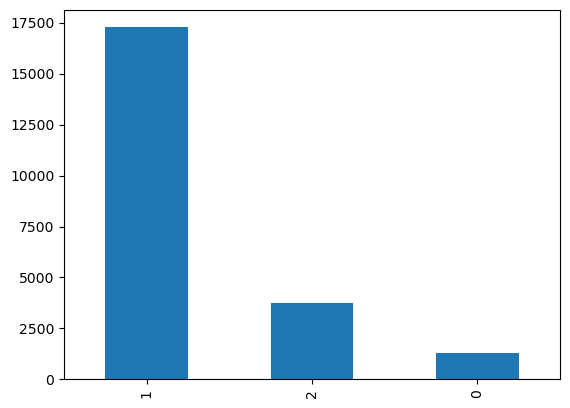

In [9]:
df_train['class'].value_counts().plot(kind='bar')

0 - Hate speech 
1 - Offensive language 
2 - None of the above

## Cleaning the texts

In [14]:
nltk.download('rslp')

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping stemmers\rslp.zip.


True

In [15]:
def preprocessing(data):
    stemmer = nltk.stem.RSLPStemmer()
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not')
    corpus = []
    for tweet in data:
      review = re.sub(r"@[A-Za-z0-9_]+", " ", tweet)
      review = re.sub('RT', ' ', review)
      review = re.sub(r"https?://[A-Za-z0-9./]+", " ", review)
      review = re.sub(r"https?", " ", review)
      review = re.sub('[^a-zA-Z]', ' ', review)
      review = review.lower()
      review = review.split()
      ps = PorterStemmer()
      review = [ps.stem(word) for word in review if not word in set(all_stopwords) if len(word) > 2]
      review = ' '.join(review)
      corpus.append(review)

    return np.array(corpus)

In [16]:
corpus = preprocessing(df_train['tweet'].values)
corpus.shape

(22304,)

In [17]:
# treino e validação do corpus
c_train, c_vad, y_train, y_vad = train_test_split(corpus, df_train['class'], test_size = 0.10, random_state = 42, stratify=df_train['class'])
c_train.shape, c_vad.shape

((20073,), (2231,))

In [18]:
def tokenize(c_train, c_vad):
    tweet_tokenizer = TweetTokenizer() 
    vectorizer = CountVectorizer(analyzer="word", tokenizer=tweet_tokenizer.tokenize, max_features = 1010)
    X_train = vectorizer.fit_transform(c_train).toarray()
    X_vad = vectorizer.transform(c_vad).toarray()
    return X_train, X_vad

In [19]:
X_train, X_vad = tokenize(c_train, c_vad)
X_train.shape, X_vad.shape

C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


((20073, 1010), (2231, 1010))

## Training Logistic Regression

In [20]:
# Logistic Regression
model = LogisticRegression(multi_class='ovr', solver='liblinear', random_state = 0)
model.fit(X_train, y_train.ravel())
y_pred = model.predict(X_vad)

# Making the Confusion Matrix

In [24]:
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_vad, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.44      0.21      0.28       129
     class 1       0.93      0.95      0.94      1727
     class 2       0.83      0.92      0.87       375

    accuracy                           0.90      2231
   macro avg       0.74      0.69      0.70      2231
weighted avg       0.89      0.90      0.89      2231



In [25]:
conjunto = c_train
hate_tweets = [sentence for sentence, label in zip(conjunto, y) if label == 0]
off_tweets = [sentence for sentence, label in zip(conjunto, y) if label == 1]
none_tweets = [sentence for sentence, label in zip(conjunto, y) if label == 2]

In [26]:
hate_words = ' '.join(hate_tweets)
off_words = ' '.join(off_tweets)
none_words = ' '.join(none_tweets)

In [27]:
def get_wordcloud(text):
    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(text)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

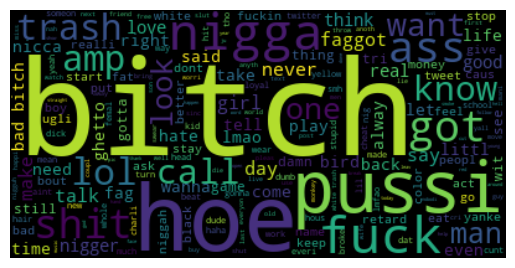

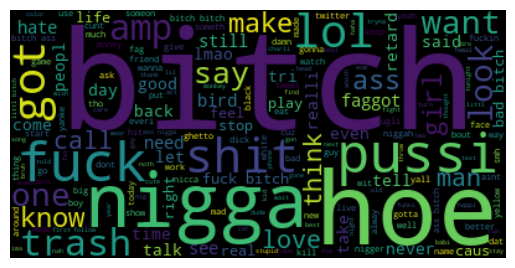

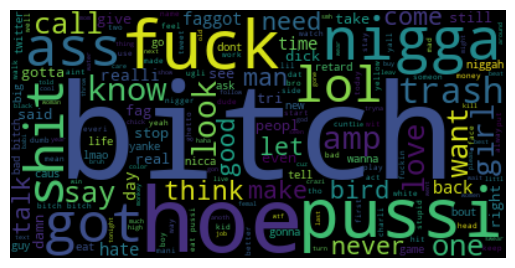

In [28]:
get_wordcloud(hate_words)
get_wordcloud(off_words)
get_wordcloud(none_words)

In [29]:
def wordListToFreqDict(wordlist):
    wordfreq = [(wordlist.count(p))/len(wordlist) for p in wordlist]
    return dict(list(zip(wordlist,wordfreq)))

In [30]:
def sortFreqDict(freqdict):
    aux = [(freqdict[key], key) for key in freqdict]
    aux.sort()
    aux.reverse()
    return aux

In [31]:
hate_dict = sortFreqDict(wordListToFreqDict(hate_words.split()))
off_dict = sortFreqDict(wordListToFreqDict(off_words.split()))
none_dict = sortFreqDict(wordListToFreqDict(none_words.split()))

In [32]:
len(hate_dict), len(off_dict), len(none_dict)

(2624, 11775, 5189)

In [33]:
def get_common(wordlist, n):
    return ([w[1] for w in wordlist])[:n]

common_words = list()
common_words.append(get_common(hate_dict, 2000))
common_words.append(get_common(off_dict, 1000))
common_words.append(get_common(none_dict, 1000))
common_words = np.unique(np.hstack(common_words))

In [34]:
common_words_dict = ({i:j for i, j in zip(common_words, range(len(common_words)))})

In [35]:
from nltk.tokenize import TweetTokenizer

# Define a custom tokenizer for tweets
tweet_tokenizer = TweetTokenizer()


In [36]:
vectorizer = CountVectorizer(analyzer="word", tokenizer=tweet_tokenizer.tokenize, vocabulary=common_words_dict)
X_train = vectorizer.fit_transform(c_train).toarray()
X_vad = vectorizer.transform(c_vad).toarray()
X_train.shape, X_vad.shape

C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


((20073, 2300), (2231, 2300))

In [37]:
# Logistic Regression
model = LogisticRegression(multi_class='ovr', solver='liblinear', random_state = 0)
model.fit(X_train, y_train.ravel())
y_pred = model.predict(X_vad)

In [39]:
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_vad, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.45      0.22      0.30       129
     class 1       0.94      0.95      0.94      1727
     class 2       0.84      0.92      0.88       375

    accuracy                           0.90      2231
   macro avg       0.74      0.70      0.71      2231
weighted avg       0.89      0.90      0.89      2231



In [40]:
n_off, n_none, n_hate = df_train['class'].value_counts()
n_hate, n_off, n_none 

(1287, 17270, 3747)

In [41]:
df_hate = df_train[df_train['class'] == 0]
df_off = df_train[df_train['class'] == 1]
df_none = df_train[df_train['class'] == 2]

In [42]:
df_off_under = df_off.sample(n_hate, random_state=0)
df_none_under = df_none.sample(n_hate, random_state=0)

df_under = pd.concat([df_hate, df_off_under, df_none_under], axis=0)
print(df_under['class'].value_counts())

0    1287
1    1287
2    1287
Name: class, dtype: int64


In [43]:
corpus_under = preprocessing(df_under['tweet'].values)

In [44]:
# treino e validação do corpus
c_train, c_vad, y_train, y_vad = train_test_split(corpus_under, df_under['class'], test_size = 0.10, random_state = 42, stratify=df_under['class'])
c_train.shape, c_vad.shape

((3474,), (387,))

In [45]:
X_train, X_vad = tokenize(c_train, c_vad)
X_train.shape, X_vad.shape

C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


((3474, 1010), (387, 1010))

In [46]:
# Logistic Regression
model = LogisticRegression(multi_class='ovr', solver='liblinear', random_state = 0)
model.fit(X_train, y_train.ravel())
y_pred = model.predict(X_vad)

In [48]:
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_vad, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.77      0.74      0.75       129
     class 1       0.78      0.80      0.79       129
     class 2       0.86      0.88      0.87       129

    accuracy                           0.80       387
   macro avg       0.80      0.80      0.80       387
weighted avg       0.80      0.80      0.80       387



In [49]:
n_off, n_none, n_hate = df_train['class'].value_counts()
n_hate, n_off, n_none 

(1287, 17270, 3747)

In [50]:
df_hate_over = df_hate.sample(n_off, replace=True, random_state=0)
df_none_over = df_none.sample(n_off, replace=True, random_state=0)
df_over = pd.concat([df_off, df_hate_over, df_none_over], axis=0)

print('Random over-sampling:')
print(df_over['class'].value_counts())

Random over-sampling:
1    17270
0    17270
2    17270
Name: class, dtype: int64


In [51]:
corpus_over = preprocessing(df_over['tweet'].values)

c_train, c_vad, y_train, y_vad = train_test_split(corpus_over, df_over['class'], test_size = 0.10, random_state = 42, stratify=df_over['class'])
c_train.shape, c_vad.shape

((46629,), (5181,))

In [52]:
X_train, X_vad = tokenize(c_train, c_vad)
X_train.shape, X_vad.shape

C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


((46629, 1010), (5181, 1010))

In [56]:
# Logistic Regression
model = LogisticRegression(multi_class='ovr', solver='liblinear', random_state = 0)
model.fit(X_train, y_train.ravel())
y_pred = model.predict(X_vad)

In [57]:

target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_vad, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.86      0.86      0.86      1727
     class 1       0.86      0.83      0.85      1727
     class 2       0.93      0.96      0.95      1727

    accuracy                           0.88      5181
   macro avg       0.88      0.88      0.88      5181
weighted avg       0.88      0.88      0.88      5181

